In [10]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import pandas as pd

from config import DATA_ROOT
from ecg_predict import batched_predict_all
from explainer import run_fused_pipeline_for_classes
from utils import import_key_data

In [11]:
# gender, age, labels, ecg_filenames = import_key_data(DATA_ROOT)

In [12]:
ROOT = Path.cwd().parent

MODEL_PATH         = ROOT / "model" / "resnet_final.keras"
SNOMED_CLASSES_NPY = ROOT / "data" / "snomed_classes.npy"
SEL_DF_CSV         = ROOT / "data" / "ecg_model_pred_data.csv"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
class_names = np.load(SNOMED_CLASSES_NPY, allow_pickle=True)

In [13]:
# probs = batched_predict_all(
#     model,
#     ecg_filenames,
#     maxlen=5000,
#     batch_size=32,
# )

# np.save("ecg_model_probs.npy", probs)
# np.save("ecg_filenames.npy", ecg_filenames)

In [14]:
from config_targets import TARGET_META
from selection import build_selection_df_with_aliases

ecg_filenames = np.load("ecg_filenames.npy", allow_pickle=True)
probs         = np.load("ecg_model_probs.npy")
class_names   = np.load("snomed_classes.npy", allow_pickle=True)

sel_df = build_selection_df_with_aliases(
    ecg_filenames=ecg_filenames,
    probs=probs,
    class_names=class_names,
    target_meta=TARGET_META,
    y_true=None,          # or y_true if you have it
    k_per_class=5,
    min_prob=0.85,
    max_duration_sec=20.0
)

sel_df.to_csv("ecg_xai_sel_meta_p0.85_k5.csv", index=False)
sel_df


[INFO] Estimating durations and keeping ECGs <= 20.0 s...
[INFO] Duration filter: keeping 40665/43101 ECGs (<= 20.0 s).
[CLASS 164889003 (atrial fibrillation)] picked 5 examples.


,group_class,filename,sel_idx,duration_sec,prob_meta
0,164889003,C:\data\ptbxl-electrocardiography-database\WFD...,34038,10.0,0.994992
1,164889003,C:\data\georgia-12lead-ecg-challenge-database\...,13158,10.0,0.966875
2,164889003,C:\data\ptbxl-electrocardiography-database\WFD...,27882,10.0,0.999998
3,164889003,C:\data\china-physiological-signal-challenge-i...,4136,10.0,0.987206
4,164889003,C:\data\georgia-12lead-ecg-challenge-database\...,12852,10.0,0.950110


<Figure size 2000x600 with 0 Axes>

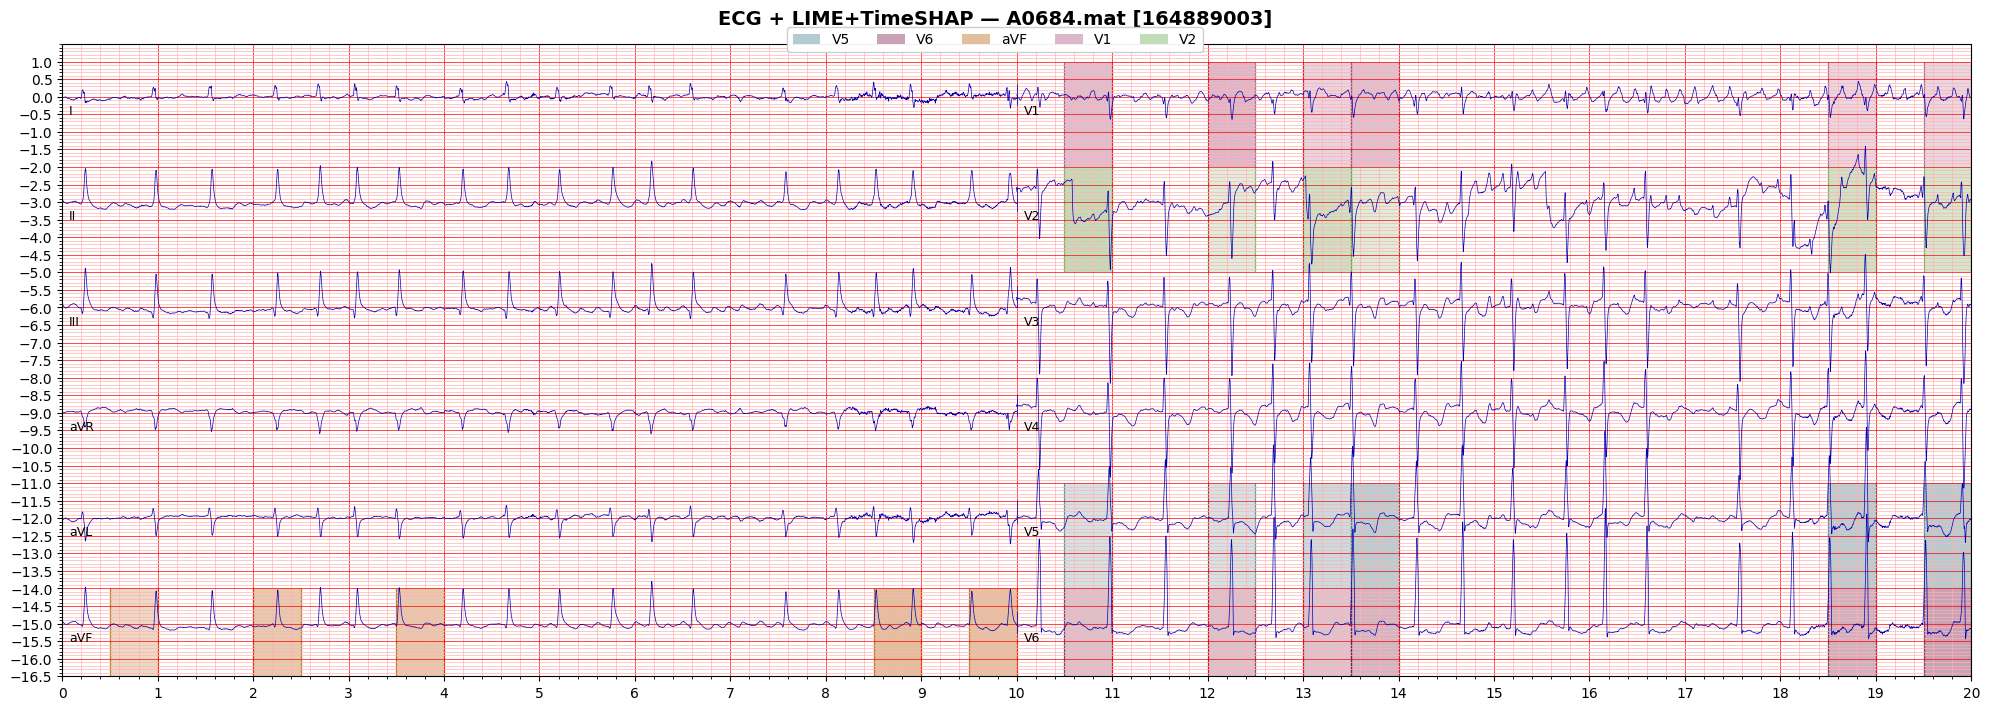

<Figure size 2000x600 with 0 Axes>

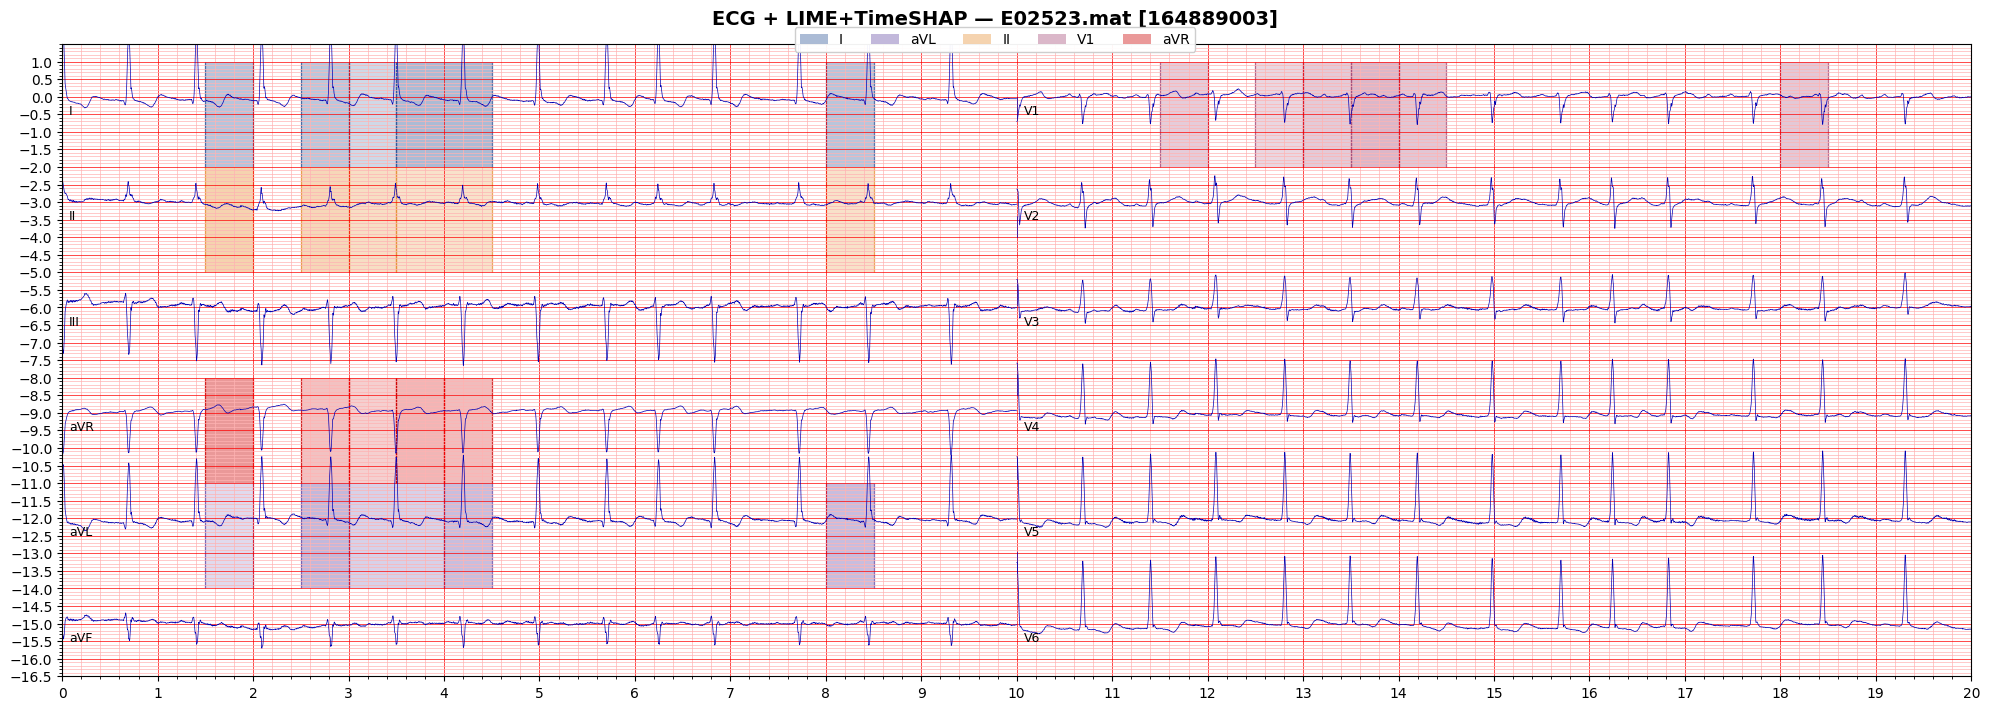

<Figure size 2000x600 with 0 Axes>

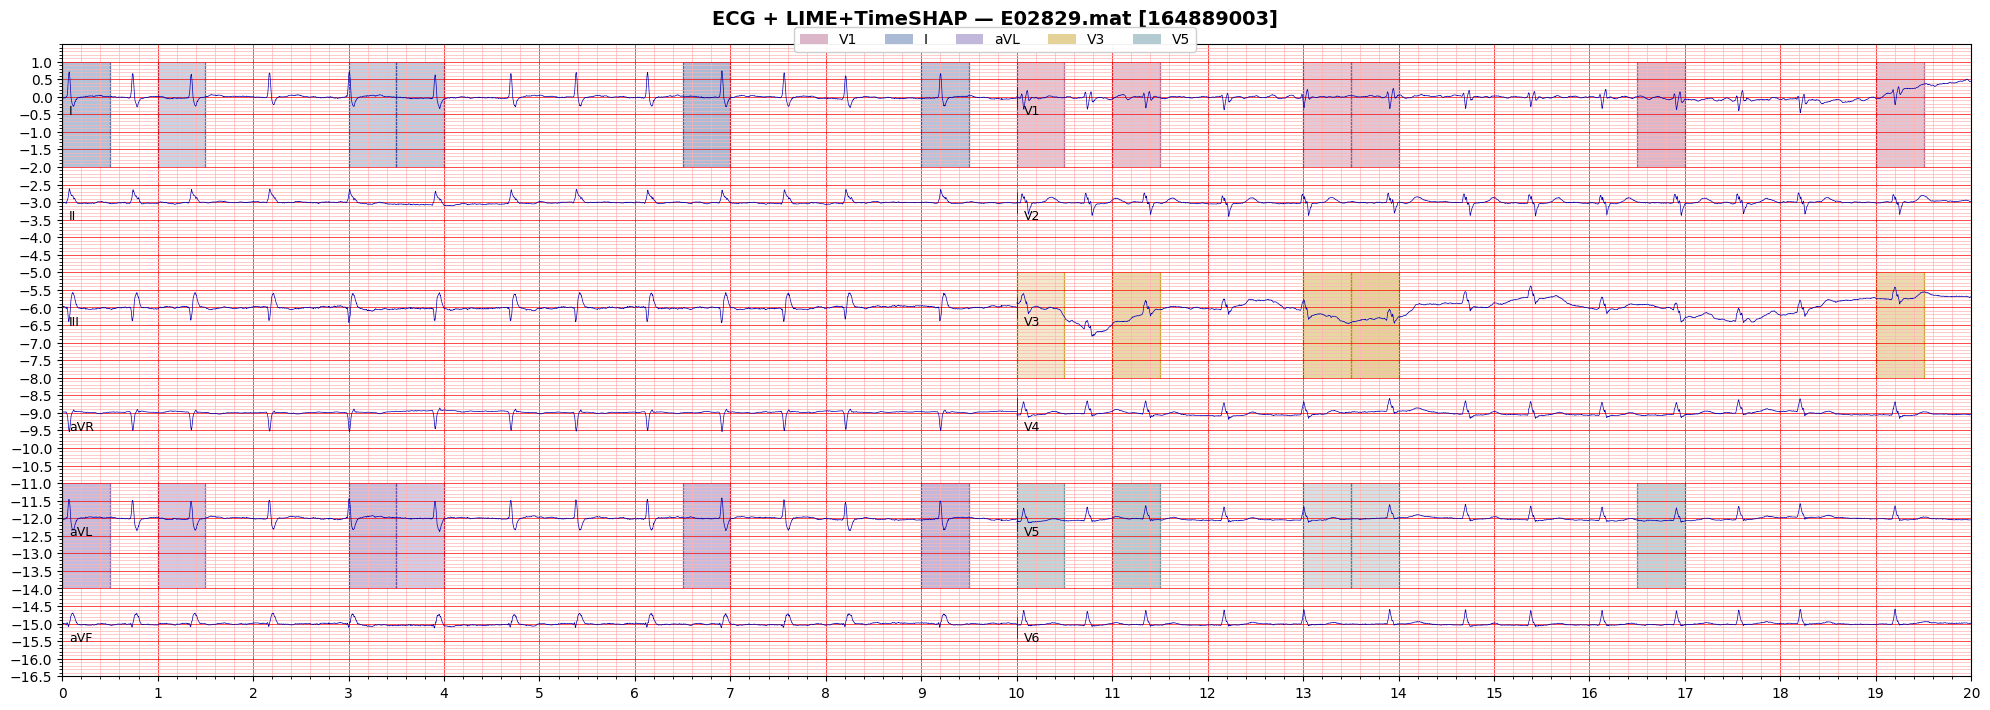

<Figure size 2000x600 with 0 Axes>

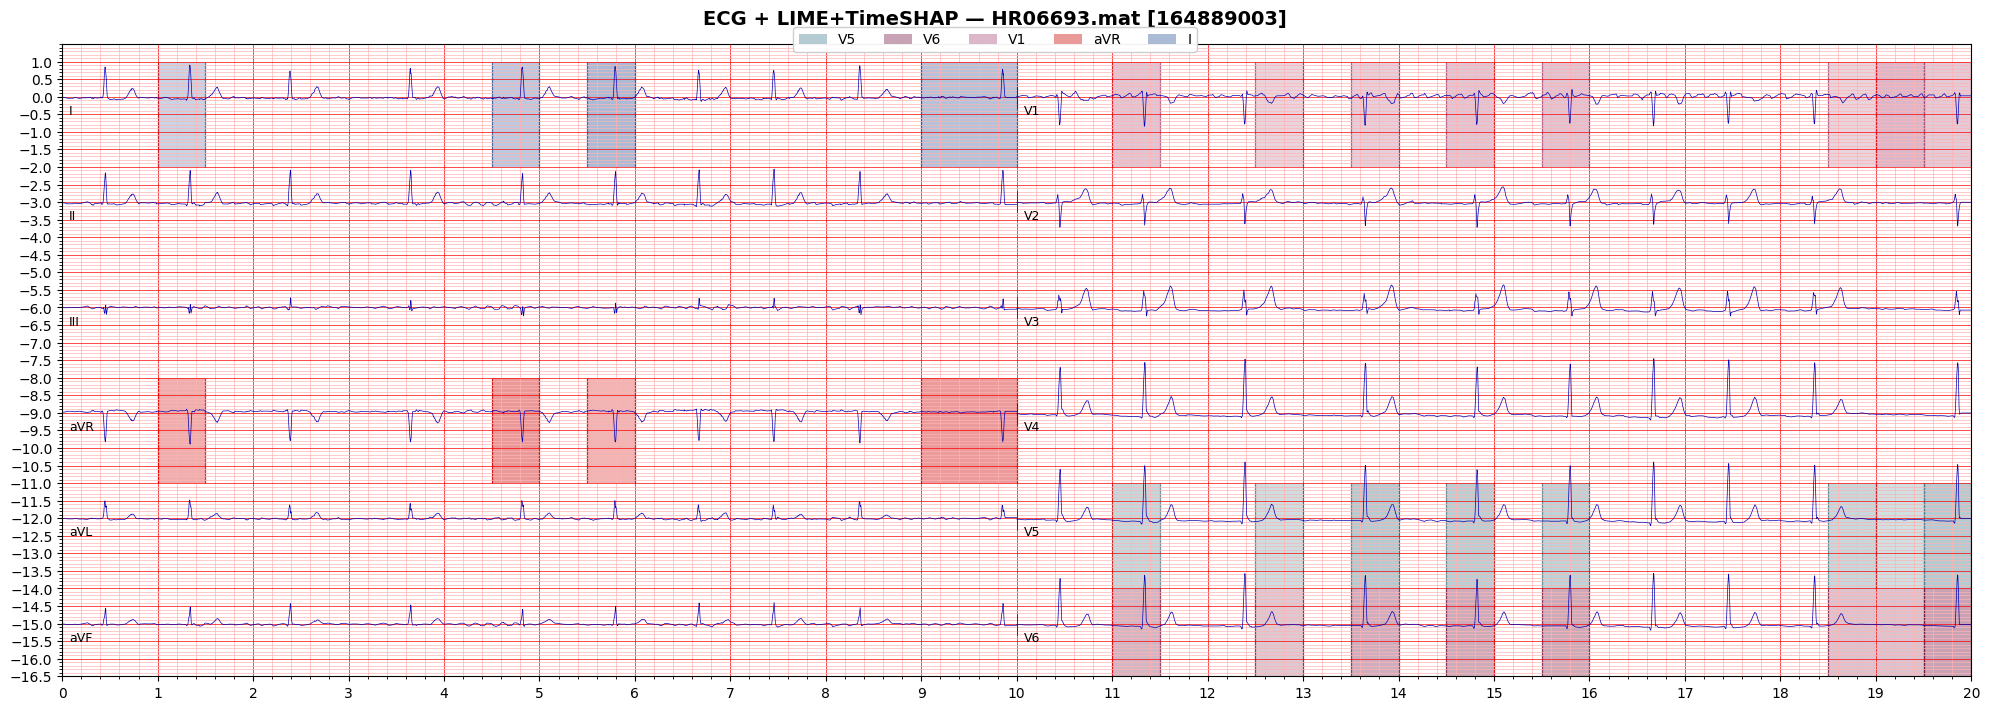

<Figure size 2000x600 with 0 Axes>

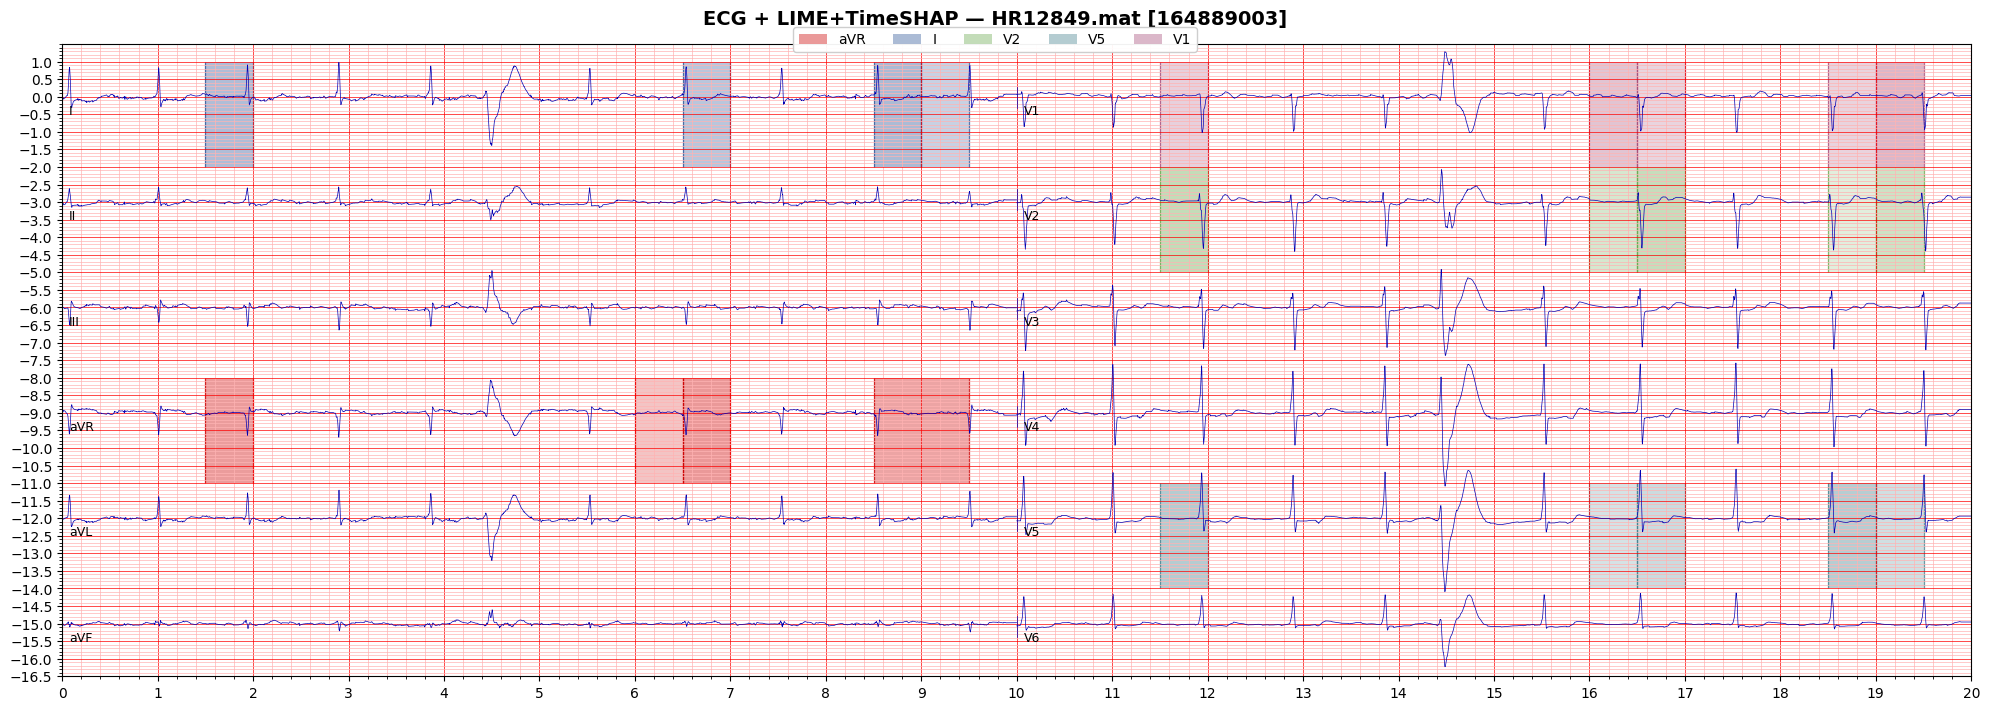

In [15]:
from explainer import run_fused_pipeline_for_classes

target_classes = list(TARGET_META.keys())   # ["164889003", "426783006", "17338001"]

all_fused_payloads, df_lime_all, df_ts_all = run_fused_pipeline_for_classes(
    target_classes=target_classes,
    sel_df=sel_df,
    model=model,
    class_names=class_names,
    max_examples_per_class=5,
    plot=True,
)


In [22]:
from pathlib import Path
from typing import Dict

from eval import evaluate_explanation, LEADS12   # your eval.py
from preprocessing import infer_fs_from_header  # you already use this

def evaluate_all_payloads(
    all_payloads: Dict[str, Dict[int, dict]],
    *,
    method_label: str | None = None,
    debug: bool = False,
) -> pd.DataFrame:
    """
    all_payloads: {meta_code -> {sel_idx -> payload}}
                  meta_code is e.g. '164889003' (AF), '426783006' (SNR), '17338001' (VPB)

    Returns a DataFrame with one row per (ECG, class, method).
    """
    rows = []

    for meta_code, cases in all_payloads.items():
        # Map SNOMED meta-code → human-readable name defined in REGISTRY
        class_name = TARGET_META[meta_code]["name"]  # e.g. "atrial fibrillation"

        for sel_idx, payload in cases.items():
            mat_path = Path(payload["mat_path"])
            hea_path = mat_path.with_suffix(".hea")

            # Sampling freq from header
            fs = infer_fs_from_header(hea_path)  # returns float or int

            # Run AttAUC (+ optional deletion curve if you later pass model_predict_proba)
            result = evaluate_explanation(
                mat_path=str(mat_path),
                fs=float(fs),
                payload=payload,
                class_name=class_name,
                rpeaks_sec=None,          # let it detect its own R-peaks
                lead_names=LEADS12,       # ("I","II",...,"V6")
                model_predict_proba=None, # AttAUC only for now
                debug=debug,
            )

            rows.append({
                "meta_code": meta_code,
                "class_name": class_name,
                "sel_idx": sel_idx,
                "mat_path": str(mat_path),
                "method": method_label or payload.get("method_label", "unknown"),

                "strict_attauc": result.strict_attauc,
                "lenient_attauc": result.lenient_attauc,
                "n_tokens": result.n_tokens,
            })

    df = pd.DataFrame(rows)
    return df

In [24]:
df_eval_all = evaluate_all_payloads(
    all_fused_payloads,
    method_label="LIME+TimeSHAP",  # or "LIME", "TimeSHAP", etc.
    debug=True
)

df_eval_all


,meta_code,class_name,sel_idx,mat_path,method,strict_attauc,lenient_attauc,n_tokens
0,164889003,atrial fibrillation,4136,C:\data\china-physiological-signal-challenge-i...,LIME+TimeSHAP,0.505679,0.723684,228
1,164889003,atrial fibrillation,12852,C:\data\georgia-12lead-ecg-challenge-database\...,LIME+TimeSHAP,0.693491,0.558432,156
2,164889003,atrial fibrillation,13158,C:\data\georgia-12lead-ecg-challenge-database\...,LIME+TimeSHAP,0.521006,0.505362,156
3,164889003,atrial fibrillation,27882,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.507851,0.581870,132
4,164889003,atrial fibrillation,34038,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.513223,0.613636,132


In [26]:
from eval import evaluate_explanation

meta_code = "164889003"   # AF meta-code
row = df_eval_all.iloc[0] # pick one AF row
sel_idx = int(row["sel_idx"])
payload = all_fused_payloads[meta_code][sel_idx]

out = evaluate_explanation(
    mat_path=payload["mat_path"],
    fs=payload.get("fs", 500.0),
    payload=payload,
    class_name=row["class_name"],   # "atrial fibrillation"
    debug=True,
)

print("Strict pos/neg:", out.debug.n_pos_strict, out.debug.n_neg_strict)
print("Lenient pos/neg:", out.debug.n_pos_lenient, out.debug.n_neg_lenient)
print("Top tokens:")
for t in out.debug.top_tokens:
    print(
        f"{t.idx:3d}  {t.lead:3s}  {t.window_type:7s}  "
        f"{t.t_start:5.2f}-{t.t_end:5.2f}  "
        f"score={t.score:7.4f}  "
        f"strict={t.strict_label}  lenient={t.lenient_label}"
    )


Strict pos/neg: 38 190
Lenient pos/neg: 152 76
Top tokens:
 63  aVR  beat      3.20- 3.90  score= 0.7402  strict=0  lenient=1
196  V5   beat      3.20- 3.90  score= 0.7362  strict=0  lenient=1
117  V1   beat      1.92- 2.62  score= 0.7143  strict=1  lenient=1
227  V6   beat      9.59-10.29  score= 0.5914  strict=0  lenient=1
 75  aVR  beat      9.59-10.29  score= 0.5914  strict=0  lenient=1
111  aVF  beat      8.59- 9.29  score= 0.5914  strict=0  lenient=1
208  V5   beat      9.59-10.29  score= 0.5848  strict=0  lenient=1
120  V1   beat      3.20- 3.90  score= 0.5683  strict=1  lenient=1
 74  aVR  beat      9.20- 9.90  score= 0.5657  strict=0  lenient=1
226  V6   beat      9.20- 9.90  score= 0.5657  strict=0  lenient=1
